In [65]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
import re
from itertools import cycle

In [66]:
pd.set_option('display.max_columns', 500)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


In [67]:
tweets = pd.read_csv('/home/jovyan/work/notebooks/tweets.csv', sep=',', header=0)

In [68]:
tweets.shape
tweets.columns

Index(['wordle_id', 'tweet_id', 'tweet_date', 'tweet_username', 'tweet_text'], dtype='object')

In [69]:
def process_tweets(tweets):
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

tweets = process_tweets(tweets)

In [70]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210


In [71]:
tweets['tweet_text'].str[:10]

0          Wordle 210
1          Wordle 210
2          Wordle 210
3          Wordle 210
4          Wordle 210
              ...    
1178449    Wordle 519
1178450    Wordle 519
1178451    Wordle 519
1178452    Wordle 519
1178453    Wordle 519
Name: tweet_text, Length: 1178454, dtype: object

In [72]:
#Quantos tweets nos temos por data?

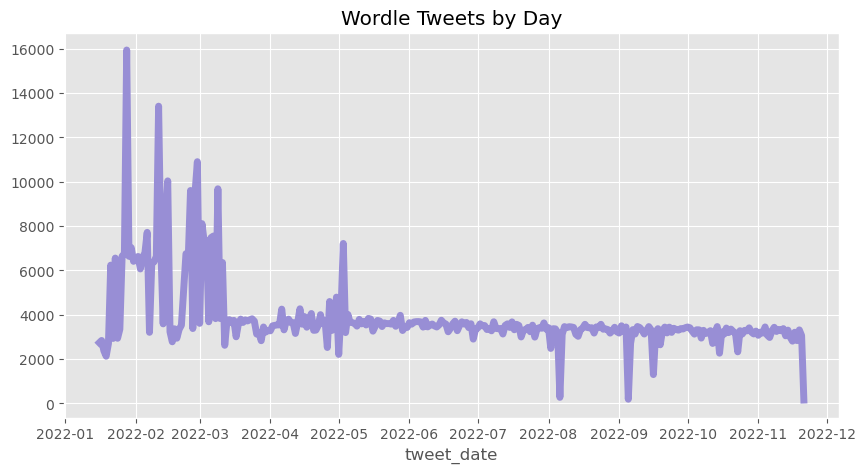

In [73]:
tweets['tweet_date'].value_counts() \
    .plot(figsize=(10, 5), title='Wordle Tweets by Day',
          color=color_pal[2], lw=5)
plt.show()

In [74]:
#Número de tentativas

In [75]:
tweets.groupby('wordle_id')['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


#Media de Tentativas

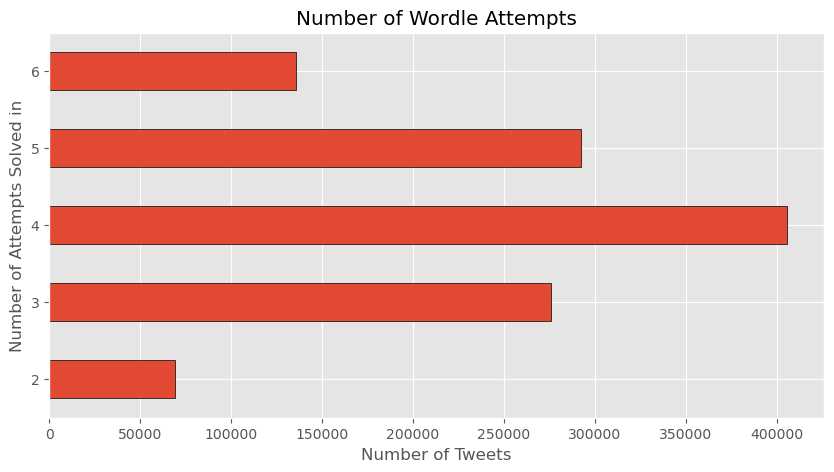

In [76]:
ax = tweets['n_attempts'].value_counts() \
    .sort_index() \
    .plot(figsize=(10, 5),
          kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

In [77]:
#Analise do texto do tweet

In [78]:
print(tweets['tweet_text'].values[323])

Wordle 210 3/6

⬛⬛🟨⬛⬛
🟨🟩🟩⬛⬛
🟩🟩🟩🟩🟩


In [79]:
# Consistencia dos quadrados pretos
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [80]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Análsie do tweet
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Conte o número de corretos, incorretos e fora do lugar
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

In [81]:
# Manter o texto adicional
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

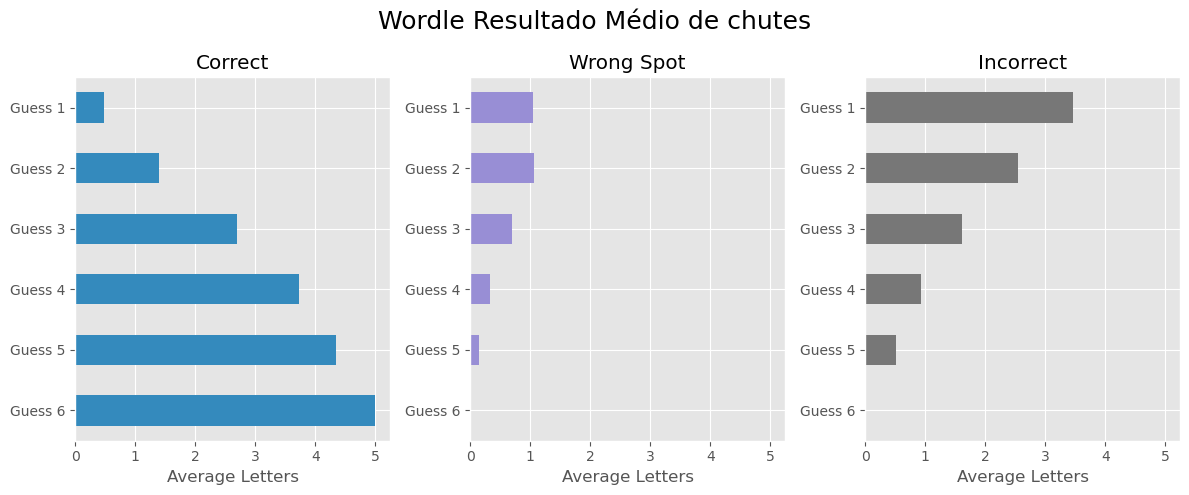

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Resultado Médio de chutes', fontsize=18)
plt.tight_layout()
plt.show()

In [87]:
answer_dict = {252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

tweets['answer'] = tweets['id'].map(answer_dict)

In [88]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

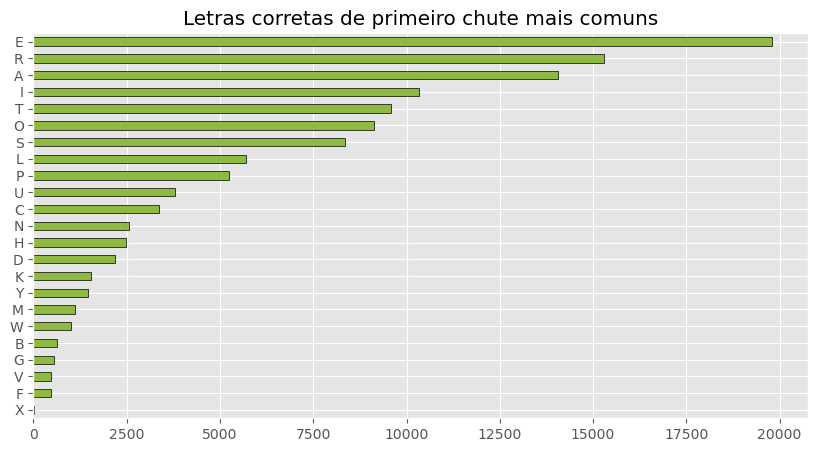

In [89]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Letras corretas de primeiro chute mais comuns',
         edgecolor='black', color=color_pal[5])
plt.show()